# Installations

In [16]:
!pip install geopandas

# Temperature Heat Map

In [17]:
import pandas as pd

df = pd.read_csv("/kaggle/input/cleaned-country/Cleaned_GlobalLandTemperaturesByCountry.csv")
df.columns

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'Month', 'Day', 'Weekday', 'Year'],
      dtype='object')

/tmp/ipykernel_34/2970291911.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


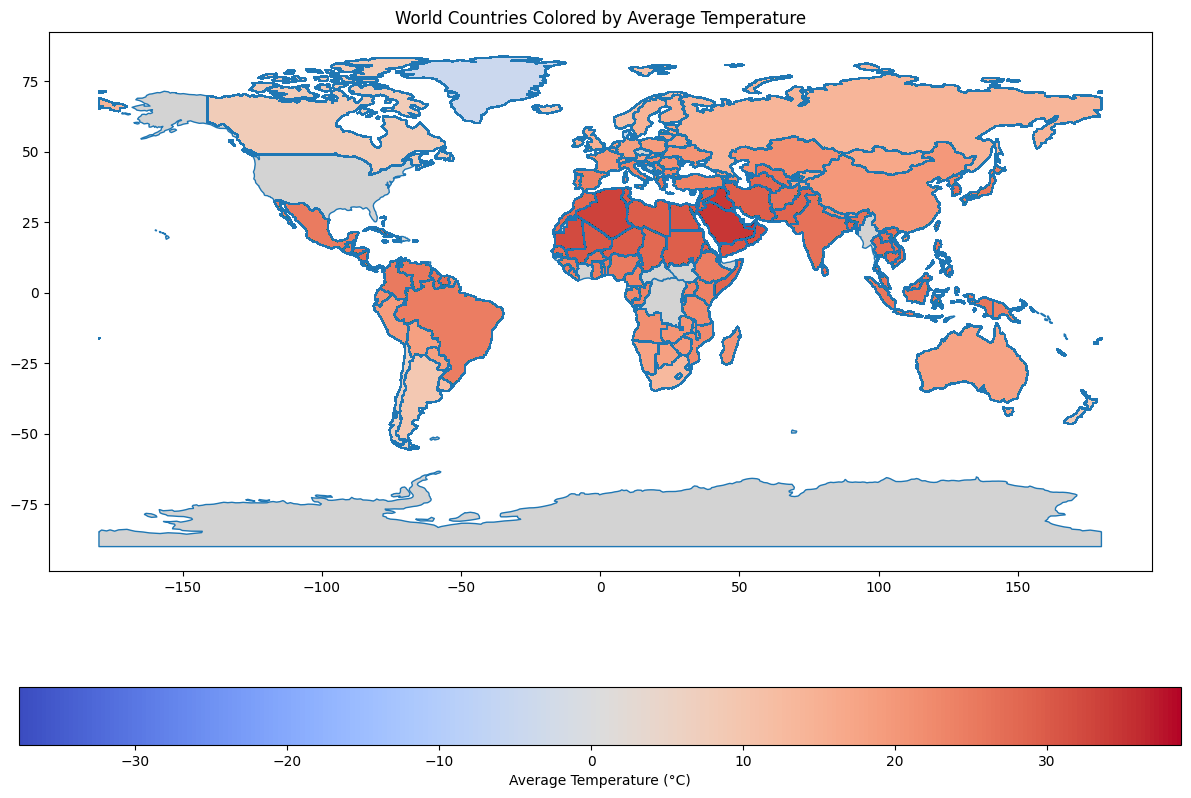

In [18]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world.merge(df, how="left", left_on="name", right_on="Country")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)
world.plot(column='AverageTemperature', ax=ax, legend=True,
           legend_kwds={'label': "Average Temperature (°C)", 'orientation': "horizontal"},
           cmap='coolwarm', missing_kwds={'color': 'lightgrey'})

plt.title('World Countries Colored by Average Temperature')
plt.show()

# Agricultural Production Heat Map

# Relationship between temperatures of a country and the crop yeilds

In [21]:
import pandas as pd

df1 = pd.read_csv("/kaggle/input/cleaned-country/Cleaned_GlobalLandTemperaturesByCountry.csv")
df2 = pd.read_csv("/kaggle/input/yield-dataset/yield_df.csv")
print(df1.columns)
print(df2.columns)

Index(['AverageTemperature', 'AverageTemperatureUncertainty', 'Country',
       'Month', 'Day', 'Weekday', 'Year'],
      dtype='object')
Index(['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp'],
      dtype='object')


In [22]:
# Merge datasets
df_merged = pd.merge(df1, df2, left_on=['Country', 'Year'], right_on=['Area', 'Year'])

# Select relevant columns (assuming we keep 'AverageTemperature' for consistency)
df_analysis = df_merged[['Country', 'Year', 'Item', 'hg/ha_yield', 'AverageTemperature']]

# Display the merged dataset ready for analysis
df_analysis

,Country,Year,Item,hg/ha_yield,AverageTemperature
0,Albania,1990,Maize,36613,2.310
1,Albania,1990,Potatoes,66667,2.310
2,Albania,1990,"Rice, paddy",23333,2.310
3,Albania,1990,Sorghum,12500,2.310
4,Albania,1990,Soybeans,7000,2.310
...,...,...,...,...,...
334020,Zimbabwe,2013,"Rice, paddy",22581,19.759
334021,Zimbabwe,2013,Sorghum,3066,19.759
334022,Zimbabwe,2013,Soybeans,13142,19.759
334023,Zimbabwe,2013,Sweet potatoes,22222,19.759


In [23]:
# Average temperature per country per year
avg_temp_per_year = df1.groupby(['Country', 'Year'])['AverageTemperature'].mean().reset_index()

# Rename columns for a clear merge
avg_temp_per_year.rename(columns={'Country': 'Area', 'AverageTemperature': 'annual_avg_temp'}, inplace=True)

# Merge with agricultural data
df = pd.merge(df2, avg_temp_per_year, how='left', on=['Area', 'Year'])
df.columns

Index(['Unnamed: 0', 'Area', 'Item', 'Year', 'hg/ha_yield',
       'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp',
       'annual_avg_temp'],
      dtype='object')

# Relationship between temperatures and agricultural yeild

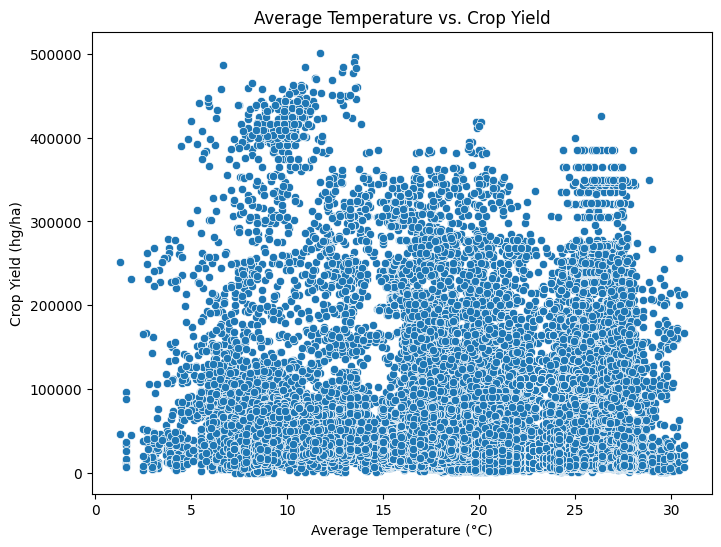

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='avg_temp', y='hg/ha_yield')
plt.title('Average Temperature vs. Crop Yield')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Crop Yield (hg/ha)')
plt.show()

# Map

In [27]:
!pip install pycountry

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 39.6 MB/s eta 0:00:0000:0100:01


In [28]:
import pycountry
import pandas as pd

# Convert country names to ISO Alpha-3 codes
def get_iso_alpha_3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None  # for countries that pycountry can't find

# Assuming `df` is your original DataFrame
df['iso_alpha'] = df['Area'].apply(get_iso_alpha_3)

# Check if there are any null values in 'iso_alpha' to ensure all countries were matched
print(df[df['iso_alpha'].isnull()]['Area'].unique())

country_agg = df.groupby('iso_alpha').agg({
    'avg_temp': 'mean',
    'hg/ha_yield': 'mean'
}).reset_index()

['Turkey']


In [29]:
import plotly.express as px

fig = px.choropleth(country_agg,
                    locations="iso_alpha",
                    color="avg_temp",
                    hover_name="iso_alpha",
                    hover_data={"avg_temp": ":.2f", "hg/ha_yield": ":.2f"},
                    color_continuous_scale=px.colors.sequential.OrRd,
                    labels={'avg_temp': 'Average Temperature (°C)', 'hg/ha_yield': 'Average Yield (hg/ha)'},
                    title='Global Temperatures and Their Impact on Agricultural Yield')

fig.update_layout(coloraxis_colorbar=dict(title="Temp (°C)"))
fig.show()

# Dashboard

In [31]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 56.5 MB/s eta 0:00:0000:010:01


In [32]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import pycountry

# Assuming 'Area' needs conversion to ISO Alpha-3
def get_iso_alpha_3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

df['iso_alpha'] = df['Area'].apply(get_iso_alpha_3)

app = dash.Dash(__name__)

app.layout = html.Div([
    dcc.Graph(id='map', figure=px.choropleth(df, locations='iso_alpha', color='avg_temp', hover_name='Area')),
    dcc.Graph(id='yield_comparison')
])

@app.callback(
    Output('yield_comparison', 'figure'),
    [Input('map', 'clickData')]
)
def update_yield_comparison(clickData):
    if clickData is None:
        # Before any country is clicked, show an empty graph
        return go.Figure()
    
    # Extract the clicked country's ISO code
    country_iso = clickData['points'][0]['location']
    selected_country = df[df['iso_alpha'] == country_iso]['Area'].iloc[0]

    # Filter data for the selected country and calculate its average yield
    selected_country_data = df[df['Area'] == selected_country]
    selected_avg_yield = selected_country_data['hg/ha_yield'].mean()
    
    # Calculate global average yield for comparison
    global_avg_yield = df['hg/ha_yield'].mean()

    # Create comparison bar chart
    fig = go.Figure(data=[
        go.Bar(name=selected_country, x=[selected_country], y=[selected_avg_yield], marker_color='blue'),
        go.Bar(name='Global Average', x=['Global Average'], y=[global_avg_yield], marker_color='red')
    ])
    
    fig.update_layout(title=f'Yield Comparison: {selected_country} vs Global Average',
                      yaxis_title='Yield (hg/ha)')

    return fig

if __name__ == '__main__':
    app.run_server(debug=True)

/tmp/ipykernel_34/3986581718.py:2: UserWarning:


The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

/tmp/ipykernel_34/3986581718.py:3: UserWarning:


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`



/tmp/ipykernel_34/3371087991.py:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0929 - val_loss: 0.0457
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - val_loss: 0.0077
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - val_loss: 0.0117
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0085
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0068
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0085
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0091
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0056
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0073
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0072
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0050


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1107 - val_loss: 0.0451
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0279 - val_loss: 0.0137
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0074
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0043 - val_loss: 0.0062
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_lo

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1133 - val_loss: 0.0404
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382 - val_loss: 0.0125
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0142
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0124
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0040
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0039
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0069
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0038
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0054


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1154 - val_loss: 0.0486
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - val_loss: 0.0071
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0040
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0055
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0057


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1135 - val_loss: 0.0461
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0260 - val_loss: 0.0109
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0036
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0058
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0038
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1475 - val_loss: 0.0554
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0432 - val_loss: 0.0061
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0038
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0034
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0122
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0058
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1268 - val_loss: 0.0580
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0361 - val_loss: 0.0071
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0036
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0053
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0029


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0924 - val_loss: 0.0370
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - val_loss: 0.0079
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0040
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0056
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0051
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0054
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1019 - val_loss: 0.0391
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - val_loss: 0.0063
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0061
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0078
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0071
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0043
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0057 - val_loss: 0.0049
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0055


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0896 - val_loss: 0.0416
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0346 - val_loss: 0.0118
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0149
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0073
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0107
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0063
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0107
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0055
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0042
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0057
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0053


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1107 - val_loss: 0.0462
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0067
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0052
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0061
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0058
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0053


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1172 - val_loss: 0.0592
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0438 - val_loss: 0.0080
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0066
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0073
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0034
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0058
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0103


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1331 - val_loss: 0.0480
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0363 - val_loss: 0.0163
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0042 - val_loss: 0.0045
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0073
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0031
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0032
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0032
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0070


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1350 - val_loss: 0.0515
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0345 - val_loss: 0.0069
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0032
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0042
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0067
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0033
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0034
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1129 - val_loss: 0.0563
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0336 - val_loss: 0.0041
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0118
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0051
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0059
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1194 - val_loss: 0.0464
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0344 - val_loss: 0.0044
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0101
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0093
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0039
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0032
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0079
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0036


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0885 - val_loss: 0.0361
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0057
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0080
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0040
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0060
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - val_loss: 0.0041
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0045 - val_loss: 0.0047
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1254 - val_loss: 0.0467
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0360 - val_loss: 0.0052
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0057
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0055
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0037
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0102
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0058
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0035


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1239 - val_loss: 0.0435
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0351 - val_loss: 0.0050
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0052
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0071
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0065
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1237 - val_loss: 0.0580
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0366 - val_loss: 0.0037
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0065
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0116
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1160 - val_loss: 0.0557
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0373 - val_loss: 0.0072
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0035
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0067
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0028
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0022
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0053


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1187 - val_loss: 0.0487
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0362 - val_loss: 0.0087
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0037
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0049
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0073
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0065
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1256 - val_loss: 0.0578
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0400 - val_loss: 0.0034
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0034
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0056
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0046
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0029
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0090
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0027


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1109 - val_loss: 0.0452
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0444 - val_loss: 0.0143
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0098
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0036
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0065
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0039
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0078
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1159 - val_loss: 0.0501
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0283 - val_loss: 0.0073
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0149
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0046
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0040 - val_loss: 0.0033
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0037 - val_loss: 0.0043
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0044
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - val_loss: 0.0052


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1212 - val_loss: 0.0510
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0373 - val_loss: 0.0054
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0064
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0087
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0061
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1100 - val_loss: 0.0467
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0316 - val_loss: 0.0074
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0038
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0039
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0066
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0074
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0049
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0053
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0863 - val_loss: 0.0421
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0308 - val_loss: 0.0060
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0073
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0044
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0067
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0090
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0077
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0079
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1258 - val_loss: 0.0487
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0399 - val_loss: 0.0088
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0100
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0061
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0041
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0065
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0079
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0058


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1251 - val_loss: 0.0476
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0424 - val_loss: 0.0106
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0103
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - val_loss: 0.0074
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0059
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0083
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0054
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1055 - val_loss: 0.0431
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0378 - val_loss: 0.0179
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0050
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0077
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0078
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0064
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0077
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0052


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1215 - val_loss: 0.0486
Epoch 2/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0433 - val_loss: 0.0052
Epoch 3/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0076
Epoch 4/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 5/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0036
Epoch 6/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0079
Epoch 7/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0050
Epoch 8/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0034
Epoch 9/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 10/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0090
Epoch 11/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0051
Epoch 12/50
89/89 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_lo

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1029 - val_loss: 0.0206
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0043
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0088
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0056
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0130
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0058
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0028
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0063
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0037


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1030 - val_loss: 0.0438
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0231 - val_loss: 0.0097
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0056
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0068
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0055
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0056
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0063
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0063


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0888 - val_loss: 0.0457
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0380 - val_loss: 0.0075
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0064
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0059
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0043
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0044
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0044
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0052


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1452 - val_loss: 0.0630
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0411 - val_loss: 0.0118
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0222
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0059
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0093
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0022
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0027


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1422 - val_loss: 0.0614
Epoch 2/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0373 - val_loss: 0.0045
Epoch 3/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 4/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0039
Epoch 5/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0046
Epoch 6/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0030
Epoch 7/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 8/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0040
Epoch 9/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 10/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0029
Epoch 11/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 12/50
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0029


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1217 - val_loss: 0.0664
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0525 - val_loss: 0.0070
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0098
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0091
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0048
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 9/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0074
Epoch 10/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 11/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0042
Epoch 12/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0059


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1310 - val_loss: 0.0668
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0469 - val_loss: 0.0058
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0062
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0082
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0057
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0050
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0066
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0095
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0034 - val_loss: 0.0081
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0073
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0028
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0041


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1522 - val_loss: 0.0775
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0615 - val_loss: 0.0348
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0200 - val_loss: 0.0099
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0069
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0075
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0034
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0096
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0049
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0026
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0052 - val_loss: 0.0076
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0021

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1472 - val_loss: 0.0609
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0259 - val_loss: 0.0049
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0062
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0055
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0071
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1309 - val_loss: 0.0665
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - val_loss: 0.0080
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0106
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0086
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0062
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0092
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0041
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0060
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0053


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1054 - val_loss: 0.0607
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0396 - val_loss: 0.0055
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0129
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0063
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0104
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0039
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0036
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0068
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0085
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0044


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1549 - val_loss: 0.0777
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0562 - val_loss: 0.0146
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0041 - val_loss: 0.0132
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0056
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0096
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0033
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0063
Epoch 10/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0046
Epoch 11/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 12/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0033


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1378 - val_loss: 0.0690
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0542 - val_loss: 0.0125
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0052
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0050
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0049
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0042
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0100
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0069
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0053
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0049
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0848 - val_loss: 0.0311
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 - val_loss: 0.0256
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0264 - val_loss: 0.0196
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - val_loss: 0.0235
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0121
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0061
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0054
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0051


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1562 - val_loss: 0.0618
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0601 - val_loss: 0.0282
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - val_loss: 0.0111
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0064
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0079
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0047
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0100
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0047


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1528 - val_loss: 0.0667
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0620 - val_loss: 0.0197
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0119
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0110
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0064
Epoch 6/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0117
Epoch 7/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0047
Epoch 8/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0032
Epoch 9/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 10/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0037
Epoch 11/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 12/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0037 - val_loss: 0.0048


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1356 - val_loss: 0.0636
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0488 - val_loss: 0.0050
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0115
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0057
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0215
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0046
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0132
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0059
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0030


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1346 - val_loss: 0.0656
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0473 - val_loss: 0.0053
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0038
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0106
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0073
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0127
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0045
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0099


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1309 - val_loss: 0.0658
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0410 - val_loss: 0.0039
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0038
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0039
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0048
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0063
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0023 - val_loss: 0.0035
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0024


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1186 - val_loss: 0.0620
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0407 - val_loss: 0.0095
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0046
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0057
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0094
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0068
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0050
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1239 - val_loss: 0.0538
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0285 - val_loss: 0.0103
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0053
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0116
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0098
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0074
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0064
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0066
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0051


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1465 - val_loss: 0.0795
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0529 - val_loss: 0.0066
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0123
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0075
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0064
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0034
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0110
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0030


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1570 - val_loss: 0.0654
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0367 - val_loss: 0.0031
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0029
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0055
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0041
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0028
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1129 - val_loss: 0.0675
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0488 - val_loss: 0.0119
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0091
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0071
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0066
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0050
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0028


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1769 - val_loss: 0.0876
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0747 - val_loss: 0.0091
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0112
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0228
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0040
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0161
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0121
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0063
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1391 - val_loss: 0.0541
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0595 - val_loss: 0.0318
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0095
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0132
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0077
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0092
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0081
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0063
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0089
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0078
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0058 - val_loss: 0.0075


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1501 - val_loss: 0.0748
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0656 - val_loss: 0.0074
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0041
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0044
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0077
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0051
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0055
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0030
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0037
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0054
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0035
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0031


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1118 - val_loss: 0.0334
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0414 - val_loss: 0.0334
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - val_loss: 0.0137
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - val_loss: 0.0136
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0109
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0153
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0106
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0090
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068 - val_loss: 0.0102
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0096
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0080


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1272 - val_loss: 0.0660
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0536 - val_loss: 0.0087
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0057
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0095
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0140
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0069
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0061
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0040
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0044


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1610 - val_loss: 0.0822
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0627 - val_loss: 0.0261
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0079
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0059
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0072
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0055
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1263 - val_loss: 0.0697
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0636 - val_loss: 0.0066
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0087
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0045
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0033
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1437 - val_loss: 0.0678
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0671 - val_loss: 0.0485
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0379 - val_loss: 0.0298
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0242
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - val_loss: 0.0090
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0147
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0069
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0103
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0066

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2066 - val_loss: 0.0909
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0795 - val_loss: 0.0024
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0061
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0014
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 9.6307e-04
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0029
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1740 - val_loss: 0.0796
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0588 - val_loss: 0.0066
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0037
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0056
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0034
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0040
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0065
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0054
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0065
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 - val_loss: 0.0031


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1559 - val_loss: 0.0771
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0589 - val_loss: 0.0070
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0133
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0082
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0112
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0035
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0053
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 11/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0028 - val_loss: 0.0024
Epoch 12/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0026


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1373 - val_loss: 0.0485
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0393 - val_loss: 0.0388
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0321 - val_loss: 0.0166
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0149 - val_loss: 0.0071
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0108
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0080
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0062
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0086
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0042


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1431 - val_loss: 0.0721
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0582 - val_loss: 0.0149
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0034
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0048
Epoch 9/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 10/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0038
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1038 - val_loss: 0.0449
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0403 - val_loss: 0.0332
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0229
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0082
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0066
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0092
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0114
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0075
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0095
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0100
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0094


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0960 - val_loss: 0.0255
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0202 - val_loss: 0.0248
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0309
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - val_loss: 0.0211
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0206
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - val_loss: 0.0218
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0099
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0165
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - val_loss: 0.0095
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0086
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0118
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0086


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0452 - val_loss: 0.0134
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0144
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0128
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0128
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0160
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0108
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0115
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0092
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0120
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0082
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0145
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0085


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0858 - val_loss: 0.0202
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - val_loss: 0.0200
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - val_loss: 0.0242
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - val_loss: 0.0266
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0254
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - val_loss: 0.0198
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0158 - val_loss: 0.0187
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - val_loss: 0.0176
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0204
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - val_loss: 0.0144
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - val_loss: 0.0148
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0113


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1128 - val_loss: 0.0640
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0450 - val_loss: 0.0506
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - val_loss: 0.0142
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0071
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0098
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0113
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0067
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0084
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0074


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0495 - val_loss: 0.0130
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0125
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - val_loss: 0.0143
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0141
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0134
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0171
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0131 - val_loss: 0.0145
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1527 - val_loss: 0.0430
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0343 - val_loss: 0.0374
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284 - val_loss: 0.0220
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0217
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0159
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0083
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0064
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0098
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0066
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0081

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1545 - val_loss: 0.0591
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0676 - val_loss: 0.0345
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0262 - val_loss: 0.0120
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0111
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0097
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0143
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0097
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0109
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0075
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0078
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0063

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0558 - val_loss: 0.0246
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0230
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - val_loss: 0.0195
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0186
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.0212
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0157
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0106
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0080
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0079

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1119 - val_loss: 0.0289
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0334 - val_loss: 0.0263
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0300 - val_loss: 0.0336
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0188 - val_loss: 0.0163
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0118
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - val_loss: 0.0127
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0098
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0105
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0104
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0114
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0091

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1180 - val_loss: 0.0427
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0398 - val_loss: 0.0414
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0313 - val_loss: 0.0219
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0086
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0113
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0090
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0086
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0083
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0065


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0675 - val_loss: 0.0113
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0102
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0073
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0078 - val_loss: 0.0091
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.0072
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0090
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0070
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0077 - val_loss: 0.0070

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0911 - val_loss: 0.0230
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0221 - val_loss: 0.0249
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0217
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_loss: 0.0124
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0109
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0084
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0158
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0085
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0083
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0073
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0070


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0879 - val_loss: 0.0327
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0319 - val_loss: 0.0342
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0287 - val_loss: 0.0328
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 - val_loss: 0.0098
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0113
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0121
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0080
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0079
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0107
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0115
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0086


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1295 - val_loss: 0.0355
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0382 - val_loss: 0.0444
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0347 - val_loss: 0.0257
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - val_loss: 0.0109
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0120
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0096
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0113
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0084
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0121
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0065
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0075 - val_loss: 0.0074


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0777 - val_loss: 0.0186
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_loss: 0.0160
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - val_loss: 0.0174
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0160
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0336
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0164
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0062
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0106
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0065 - val_loss: 0.0057
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0086
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0084

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1240 - val_loss: 0.0662
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0546 - val_loss: 0.0242
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0067 - val_loss: 0.0101
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0095
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0114
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0063
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0081
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0058
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0065

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1121 - val_loss: 0.0355
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0307 - val_loss: 0.0351
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0289 - val_loss: 0.0438
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0268 - val_loss: 0.0292
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - val_loss: 0.0348
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0217
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0098
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0198
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0117
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0152
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0092
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0090


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1304 - val_loss: 0.0589
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0504 - val_loss: 0.0495
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0263 - val_loss: 0.0311
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0215
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0180
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0089
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0114
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0102
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0085
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0132
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0101

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1548 - val_loss: 0.0767
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0675 - val_loss: 0.0040
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0158
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0042
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0068
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0068
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0038
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1363 - val_loss: 0.0660
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0539 - val_loss: 0.0079
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0049
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0136
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0101
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0057
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0051
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 10/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0032
Epoch 11/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0043
Epoch 12/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0042


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1852 - val_loss: 0.0770
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0638 - val_loss: 0.0323
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0096
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0089
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0051
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0112
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0055
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0030

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0934 - val_loss: 0.0220
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0252 - val_loss: 0.0248
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244 - val_loss: 0.0282
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0213 - val_loss: 0.0143
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0135 - val_loss: 0.0196
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0078
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0075
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0133
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0075
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_lo

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1676 - val_loss: 0.0820
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0623 - val_loss: 0.0254
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0047
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0029
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0052
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0057
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0053
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1466 - val_loss: 0.0821
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0616 - val_loss: 0.0057
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0062 - val_loss: 0.0093
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0080
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0053
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1795 - val_loss: 0.0794
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0662 - val_loss: 0.0047
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0039
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0036
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0031
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0047
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0037
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0066
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0025


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1529 - val_loss: 0.0905
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0711 - val_loss: 0.0106
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0124
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0098
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0060
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0057
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022 - val_loss: 0.0077
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0037
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0058

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1386 - val_loss: 0.0619
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0604 - val_loss: 0.0142
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0147
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0076
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0052
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0056
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0062
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0033 - val_loss: 0.0070
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0082
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0075

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1394 - val_loss: 0.0714
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0540 - val_loss: 0.0026
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0057
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0023
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0075
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0031
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0015


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1434 - val_loss: 0.0754
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0566 - val_loss: 0.0027
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0065
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0017 - val_loss: 0.0049
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 11/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 12/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0014 - val_loss: 0.0016

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1588 - val_loss: 0.1046
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0735 - val_loss: 0.0115
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0145
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0062
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0114
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0125
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0076
Epoch 9/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0073
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1451 - val_loss: 0.0827
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0689 - val_loss: 0.0364
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0303
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0137
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0091
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0059
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0035 - val_loss: 0.0086
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 0.0121
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0029 - val_loss: 0.0113
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0022 - val_loss: 0.0070
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0056

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1568 - val_loss: 0.0873
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0797 - val_loss: 0.0370
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0214 - val_loss: 0.0233
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0257
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0131
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0146
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0099
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0052
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0149
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0046 - val_loss: 0.0068
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0099

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1273 - val_loss: 0.0749
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0521 - val_loss: 0.0203
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0069
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0061
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0089
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0078
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0036 - val_loss: 0.0103
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0064
Epoch 9/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 10/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0040
Epoch 11/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - val_loss: 0.0049
Epoch 12/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - val_loss: 0.0068


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1247 - val_loss: 0.0539
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - val_loss: 0.0508
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0411 - val_loss: 0.0388
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0295 - val_loss: 0.0256
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191 - val_loss: 0.0308
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0280
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0172
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0165
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - val_loss: 0.0175
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - val_loss: 0.0157
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0130
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0182

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1535 - val_loss: 0.0884
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0717 - val_loss: 0.0162
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0129
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0111
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0185
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0071
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0104
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0044
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0054
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0048

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1001 - val_loss: 0.0389
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - val_loss: 0.0373
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0315 - val_loss: 0.0346
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0271 - val_loss: 0.0212
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0065
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0068
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0064
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0060
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0060
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0051
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0074

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0772 - val_loss: 0.0350
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0337 - val_loss: 0.0314
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0301 - val_loss: 0.0233
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - val_loss: 0.0208
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0137
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0133
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0117
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - val_loss: 0.0107
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0120
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0134

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0916 - val_loss: 0.0428
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0392 - val_loss: 0.0432
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0368 - val_loss: 0.0431
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0273 - val_loss: 0.0151
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0157 - val_loss: 0.0129
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - val_loss: 0.0135
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0180
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0187
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0142
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0118
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0101
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0129

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1003 - val_loss: 0.0318
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0243 - val_loss: 0.0274
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0228 - val_loss: 0.0267
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0224 - val_loss: 0.0277
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - val_loss: 0.0204
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_loss: 0.0121
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 - val_loss: 0.0135
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0196
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0111
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - val_loss: 0.0097
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - val_loss: 0.0097
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - val_loss: 0.0098

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0875 - val_loss: 0.0399
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0331 - val_loss: 0.0376
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0331 - val_loss: 0.0395
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0257 - val_loss: 0.0283
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_loss: 0.0258
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0099
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0195
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0108
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0131
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0071
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0087
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0081

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1453 - val_loss: 0.0705
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0711 - val_loss: 0.0553
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290 - val_loss: 0.0167
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0132 - val_loss: 0.0147
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0120
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0102
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0182
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0138
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0102
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0169
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - val_loss: 0.0084
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0061 - val_loss: 0.0110

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0810 - val_loss: 0.0418
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0322 - val_loss: 0.0402
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0299 - val_loss: 0.0336
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0265 - val_loss: 0.0255
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_loss: 0.0103
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0075
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0150
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0054
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0066
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0098
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0088

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1125 - val_loss: 0.0512
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0365 - val_loss: 0.0507
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0328 - val_loss: 0.0322
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0261 - val_loss: 0.0108
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0105
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0136
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0110
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0105
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0114
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0080
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0091

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0775 - val_loss: 0.0368
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244 - val_loss: 0.0286
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0246 - val_loss: 0.0322
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0222
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.0121
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0162
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0088
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0082
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0112
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0089
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0110

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0474 - val_loss: 0.0278
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0211 - val_loss: 0.0316
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0200 - val_loss: 0.0275
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0096
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0108
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0150
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0101
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0124
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0538 - val_loss: 0.0169
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0144
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0154
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0169
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0154
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0185
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - val_loss: 0.0155
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0800 - val_loss: 0.0382
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0309 - val_loss: 0.0400
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0297 - val_loss: 0.0448
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0288 - val_loss: 0.0344
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0136
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0075
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - val_loss: 0.0157
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0089
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0102
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0127
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1515 - val_loss: 0.0429
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0432 - val_loss: 0.0442
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0401 - val_loss: 0.0335
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0392 - val_loss: 0.0252
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0267 - val_loss: 0.0254
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - val_loss: 0.0170
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0178
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0114 - val_loss: 0.0127
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0126
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0086
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0120

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1243 - val_loss: 0.0505
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0518 - val_loss: 0.0444
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0465 - val_loss: 0.0276
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0249 - val_loss: 0.0111
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0141
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0112
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0270
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0082
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0085
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - val_loss: 0.0074
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0079 - val_loss: 0.0114

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1435 - val_loss: 0.0472
Epoch 2/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0499 - val_loss: 0.0515
Epoch 3/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0470 - val_loss: 0.0334
Epoch 4/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0328 - val_loss: 0.0148
Epoch 5/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0176 - val_loss: 0.0129
Epoch 6/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0135
Epoch 7/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0129
Epoch 8/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0136
Epoch 9/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - val_loss: 0.0125
Epoch 10/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - val_loss: 0.0135
Epoch 11/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0115
Epoch 12/50
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0086

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1384 - val_loss: 0.0613
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0623 - val_loss: 0.0401
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338 - val_loss: 0.0120
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0169 - val_loss: 0.0112
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0185 - val_loss: 0.0099
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0101
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.0263
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0118
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - val_loss: 0.0078
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - val_loss: 0.0071
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0173
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0050

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1114 - val_loss: 0.0482
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0411 - val_loss: 0.0415
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0375 - val_loss: 0.0589
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0327 - val_loss: 0.0204
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0223
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_loss: 0.0170
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0128 - val_loss: 0.0185
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0157
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0110 - val_loss: 0.0191
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - val_loss: 0.0132
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0152
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0265

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1624 - val_loss: 0.0612
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0608 - val_loss: 0.0457
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0362 - val_loss: 0.0120
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - val_loss: 0.0161
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0111
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0094
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0049
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0086
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0097
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0054

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0858 - val_loss: 0.0417
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0303 - val_loss: 0.0565
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0306 - val_loss: 0.0359
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0257 - val_loss: 0.0351
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - val_loss: 0.0272
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - val_loss: 0.0211
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0175
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0142
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - val_loss: 0.0132
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0156
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0155
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0212

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0806 - val_loss: 0.0244
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0161 - val_loss: 0.0189
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0142 - val_loss: 0.0160
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0176
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - val_loss: 0.0177
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - val_loss: 0.0152
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0134 - val_loss: 0.0150
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0161
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0186
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0166
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0180
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0129

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0769 - val_loss: 0.0249
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - val_loss: 0.0208
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - val_loss: 0.0220
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - val_loss: 0.0186
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0215
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0129
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0109
Epoch 8/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0084 - val_loss: 0.0099
Epoch 9/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 10/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - val_loss: 0.0165
Epoch 11/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0084
Epoch 12/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0084

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1808 - val_loss: 0.0863
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0788 - val_loss: 0.0366
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - val_loss: 0.0106
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0104
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0054
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0053
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0069
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1099 - val_loss: 0.0277
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0275 - val_loss: 0.0213
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244 - val_loss: 0.0321
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0231 - val_loss: 0.0177
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0130
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0176
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0069
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0077 - val_loss: 0.0102
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0069
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0061
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0067
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0087

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1288 - val_loss: 0.0588
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0530 - val_loss: 0.0187
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0052
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0052
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0058
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0068
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0057
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0053
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1621 - val_loss: 0.0824
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0691 - val_loss: 0.0413
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0391
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0153
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0061
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0080
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0129
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0029
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0059
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0031

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1250 - val_loss: 0.0728
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0569 - val_loss: 0.0132
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0085
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0123
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0060
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0026
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1343 - val_loss: 0.0632
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0473 - val_loss: 0.0558
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0423 - val_loss: 0.0310
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0214 - val_loss: 0.0158
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0151 - val_loss: 0.0131
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.0209
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0122 - val_loss: 0.0147
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0101 - val_loss: 0.0118
Epoch 9/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0110
Epoch 10/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0086 - val_loss: 0.0108
Epoch 11/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0119
Epoch 12/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0124

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0851 - val_loss: 0.0247
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0244 - val_loss: 0.0207
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0212 - val_loss: 0.0216
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0215 - val_loss: 0.0187
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 - val_loss: 0.0137
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0107
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0108 - val_loss: 0.0098
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0080
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0062
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0074
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0062
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0089

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0790 - val_loss: 0.0441
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355 - val_loss: 0.0386
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - val_loss: 0.0272
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0227 - val_loss: 0.0239
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0151 - val_loss: 0.0118
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - val_loss: 0.0294
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - val_loss: 0.0156
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0119 - val_loss: 0.0097
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0137
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0154
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0122
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0106

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0955 - val_loss: 0.0279
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0237 - val_loss: 0.0247
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0237 - val_loss: 0.0236
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0233 - val_loss: 0.0208
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - val_loss: 0.0151
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0170 - val_loss: 0.0103
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0129 - val_loss: 0.0103
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0121 - val_loss: 0.0111
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0112 - val_loss: 0.0121
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0090
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0088
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0086

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0780 - val_loss: 0.0418
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0316 - val_loss: 0.0372
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0290 - val_loss: 0.0312
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - val_loss: 0.0142
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - val_loss: 0.0113
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0341
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0137 - val_loss: 0.0127
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0109
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - val_loss: 0.0103
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0105
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0105 - val_loss: 0.0112
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0111

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1202 - val_loss: 0.0457
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0471 - val_loss: 0.0395
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0395 - val_loss: 0.0170
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0121
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0143 - val_loss: 0.0130
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - val_loss: 0.0124
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0204
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0104
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0138
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0096
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0088 - val_loss: 0.0077
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0071

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0824 - val_loss: 0.0304
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282 - val_loss: 0.0251
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0265 - val_loss: 0.0226
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0244 - val_loss: 0.0159
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_loss: 0.0082
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - val_loss: 0.0187
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0138
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - val_loss: 0.0097
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0092 - val_loss: 0.0073
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0062
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0082 - val_loss: 0.0073
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0086

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1627 - val_loss: 0.0494
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0514 - val_loss: 0.0442
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0419 - val_loss: 0.0224
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0178 - val_loss: 0.0203
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0123 - val_loss: 0.0335
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0125 - val_loss: 0.0231
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0124 - val_loss: 0.0188
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - val_loss: 0.0095
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - val_loss: 0.0084
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0087 - val_loss: 0.0073

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1561 - val_loss: 0.0765
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0696 - val_loss: 0.0263
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0168 - val_loss: 0.0118
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0067
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0052 - val_loss: 0.0037
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0036
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0053
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0034 - val_loss: 0.0028

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1463 - val_loss: 0.0683
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0638 - val_loss: 0.0325
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0187 - val_loss: 0.0259
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0106 - val_loss: 0.0194
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - val_loss: 0.0154
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0104
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0095
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0068
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0057
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0075
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0055
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0072

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1466 - val_loss: 0.0739
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0632 - val_loss: 0.0500
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0328 - val_loss: 0.0373
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0093 - val_loss: 0.0095
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0087
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0251
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - val_loss: 0.0130
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0083
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - val_loss: 0.0071
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0068
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0061

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1176 - val_loss: 0.0688
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0596 - val_loss: 0.0173
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.0049
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0168
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0078 - val_loss: 0.0068
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0061 - val_loss: 0.0058
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0036
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0045 - val_loss: 0.0107
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0054 - val_loss: 0.0033

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1558 - val_loss: 0.0529
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0512 - val_loss: 0.0529
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0468 - val_loss: 0.0391
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0357 - val_loss: 0.0219
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0194 - val_loss: 0.0266
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0187 - val_loss: 0.0188
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - val_loss: 0.0187
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0158
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0151
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - val_loss: 0.0282
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0132 - val_loss: 0.0167
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0133

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1185 - val_loss: 0.0589
Epoch 2/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0490 - val_loss: 0.0315
Epoch 3/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0085 - val_loss: 0.0286
Epoch 4/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0191
Epoch 5/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0070
Epoch 6/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 7/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0091
Epoch 8/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0083
Epoch 9/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0053 - val_loss: 0.0093
Epoch 10/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0038 - val_loss: 0.0058
Epoch 11/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 12/50
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0051

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1488 - val_loss: 0.0791
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0660 - val_loss: 0.0467
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0177 - val_loss: 0.0139
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0088
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0036 - val_loss: 0.0170
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0050 - val_loss: 0.0147
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0168
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0104
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0038 - val_loss: 0.0071
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0039 - val_loss: 0.0074
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0031 - val_loss: 0.0040

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1244 - val_loss: 0.0555
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0599 - val_loss: 0.0455
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0448 - val_loss: 0.0245
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0098 - val_loss: 0.0262
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0090 - val_loss: 0.0138
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0071 - val_loss: 0.0108
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0258
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0070 - val_loss: 0.0155
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0135
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - val_loss: 0.0136
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0058 - val_loss: 0.0119
Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0594 - val_loss: 0.0168
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191 - val_loss: 0.0151
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0182 - val_loss: 0.0155
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0173 - val_loss: 0.0129
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.0083
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - val_loss: 0.0063
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0057
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0056
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0071
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0099 - val_loss: 0.0050
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0076 - val_loss: 0.0055
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0080 - val_loss: 0.0060

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1099 - val_loss: 0.0435
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0416 - val_loss: 0.0408
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0387 - val_loss: 0.0328
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0287 - val_loss: 0.0097
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - val_loss: 0.0049
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0081 - val_loss: 0.0106
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0089 - val_loss: 0.0054
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0050
Epoch 9/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0080 - val_loss: 0.0067
Epoch 10/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0076 - val_loss: 0.0045
Epoch 11/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0071 - val_loss: 0.0053
Epoch 12/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0072 - val_loss: 0.0050

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1289 - val_loss: 0.0917
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0609 - val_loss: 0.1058
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0059 - val_loss: 0.0091
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0042 - val_loss: 0.0058
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0060 - val_loss: 0.0086
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0254
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - val_loss: 0.0093
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0030 - val_loss: 0.0065
Epoch 10/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0045
Epoch 11/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - val_loss: 0.0119
Epoch 12/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0029 - val_loss: 0.0057

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0907 - val_loss: 0.0290
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0231 - val_loss: 0.0219
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - val_loss: 0.0225
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0203 - val_loss: 0.0192
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - val_loss: 0.0245
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0227 - val_loss: 0.0187
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0193 - val_loss: 0.0160
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0201 - val_loss: 0.0165
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 - val_loss: 0.0187
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0189 - val_loss: 0.0167
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0136 - val_loss: 0.0158
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0115 - val_loss: 0.0079

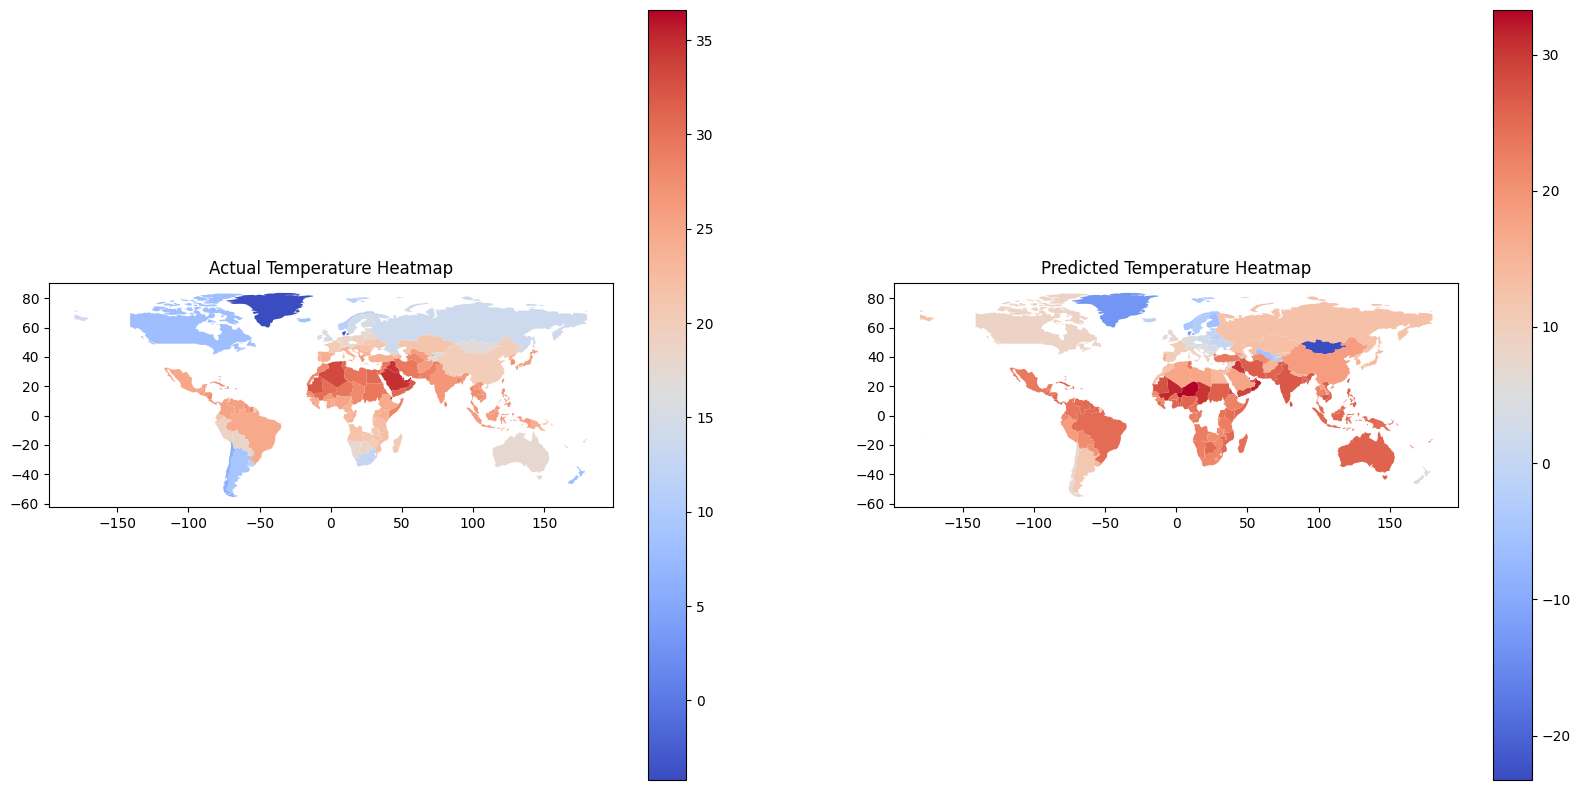

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Function to create sequences for LSTM
def create_sequences(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Read the cleaned dataset
cleaned_df = pd.read_csv('/kaggle/input/cleaned-country/Cleaned_GlobalLandTemperaturesByCountry.csv')

# Create a datetime column
cleaned_df['dt'] = pd.to_datetime(cleaned_df[['Year', 'Month', 'Day']])

# Drop the original 'Year', 'Month', and 'Day' columns
cleaned_df = cleaned_df.drop(['Year', 'Month', 'Day'], axis=1)

# Sort the dataframe by date
cleaned_df = cleaned_df.sort_values(by='dt')

# Set 'dt' column as index
cleaned_df.set_index('dt', inplace=True)

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Initialize columns for actual and predicted temperatures
world['ActualTemp'] = np.nan
world['PredictedTemp'] = np.nan

# Get a list of all countries in the dataset
all_countries = cleaned_df['Country'].unique()

# Process each country
for country in all_countries:
    country_df = cleaned_df[cleaned_df['Country'] == country]
    if country_df.empty or world[world['name'] == country].empty:
        continue  # Skip if no data for the country

    temperature_data = country_df['AverageTemperature'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    temperature_data_scaled = scaler.fit_transform(temperature_data)
    look_back = 12
    X, y = create_sequences(temperature_data_scaled, look_back)
    X = X.reshape(X.shape[0], look_back, 1)

    # LSTM model setup
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stopping])

    future_days = 365
    lst_output = []
    n_steps = len(X)

    for i in range(future_days):
        if i < n_steps:
            lst_output.append(temperature_data_scaled[-n_steps + i, 0])
        else:
            x_input = np.array(lst_output[-look_back:]).reshape((1, look_back, 1))
            yhat = model.predict(x_input, verbose=0)
            lst_output.append(yhat[0, 0])

    future_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1, 1))

    # Update the world map with the latest actual temperature and last predicted temperature
    world.loc[world['name'] == country, 'ActualTemp'] = country_df['AverageTemperature'].iloc[-1]
    world.loc[world['name'] == country, 'PredictedTemp'] = future_predictions[-1][0]

# Plotting the actual temperature heatmap on the world map
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
world.dropna(subset=['ActualTemp']).plot(column='ActualTemp', ax=ax[0], legend=True, cmap='coolwarm')
ax[0].set_title('Actual Temperature Heatmap')

# Plotting the predicted temperature heatmap on the world map
world.dropna(subset=['PredictedTemp']).plot(column='PredictedTemp', ax=ax[1], legend=True, cmap='coolwarm')
ax[1].set_title('Predicted Temperature Heatmap')

plt.show()
